In [1]:
import yaml
from pathlib import Path
import pandas as pd
from src.data_loader import load_parquet
from src.pair_selection import analyze_pairs  # ton fichier déjà fourni
from src.pair_selection_dynamic import analyze_pairs_dynamic, DynamicPairParams

In [2]:
params = yaml.safe_load(Path("../config/params.yaml").read_text())
path_close = params["paths"]["processed_close"]
min_lookback = params["pairs"]["min_lookback"]
fdr_alpha = params["pairs"]["fdr_alpha"]
hl_min = params["pairs"]["hl_min"]
hl_max = params["pairs"]["hl_max"]

In [3]:
prices = load_parquet(f"../{path_close}")
prices.head(), prices.shape

(Ticker                           BAC         BK          C          GS  \
 Datetime                                                                 
 2024-10-09 15:30:00+02:00  39.910000  73.459999  63.555000  498.095001   
 2024-10-09 16:30:00+02:00  40.185001  73.919998  63.933998  503.790009   
 2024-10-09 17:30:00+02:00  40.215000  73.910004  63.993599  504.084991   
 2024-10-09 18:30:00+02:00  40.279999  74.048599  64.121902  505.010010   
 2024-10-09 19:30:00+02:00  40.095001  73.790001  64.074997  504.109985   
 
 Ticker                            JPM          MS         PNC        USB  \
 Datetime                                                                   
 2024-10-09 15:30:00+02:00  211.550003  107.945000  181.740005  44.650002   
 2024-10-09 16:30:00+02:00  213.289993  108.599998  183.149994  45.055000   
 2024-10-09 17:30:00+02:00  213.329895  108.750000  183.330002  44.990002   
 2024-10-09 18:30:00+02:00  213.910004  108.900002  183.634995  44.974998   
 2024-10-09

In [4]:
pairs = analyze_pairs(
    prices=prices,
    min_lookback=min_lookback,
    pvalue_threshold=fdr_alpha,
    hl_min=hl_min,
    hl_max=hl_max,
    verbose=False
)
pairs.head(15)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [100]:
out_csv = Path("../data/processed/pair_candidates_1h.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
pairs.to_csv(out_csv, index=False)
out_csv

WindowsPath('../data/processed/pair_candidates_1h.csv')

In [101]:
print(pairs[['pvalue','half_life','spread_mean','spread_vol']].describe())

          pvalue    half_life   spread_mean  spread_vol
count  36.000000    36.000000  3.600000e+01   36.000000
mean    0.521564   463.892875  3.695167e-14   12.183077
std     0.325541   720.273641  9.165951e-13   17.502224
min     0.047508    54.185820 -3.137181e-12    1.084277
25%     0.225351    86.914436 -1.983714e-13    2.648671
50%     0.478212   160.646264 -1.046599e-14    5.614149
75%     0.848667   364.241861  2.306116e-13   11.349084
max     0.976581  3311.265491  2.980715e-12   79.308910


In [102]:
pairs['fdr_reject'].describe()

count        36
unique        1
top       False
freq         36
Name: fdr_reject, dtype: object

In [ ]:
dyn_params = DynamicPairParams(
    delta=1e-3,        # plus grand => β_t/α_t s'ajustent plus vite
    obs_var=1.0,       # variance du bruit d'observation
    roll_window=250,   # ~1 an trading (daily)
    roll_step=10,
    roll_trend="c",    # "ct" possible si drift linéaire
    roll_pthresh=0.05,
    min_lookback=250
)

pairs_dyn = analyze_pairs_dynamic(prices, params=dyn_params, compute_rolling_coint=True)
pairs_dyn.head(100)

C:\Donnees\Business\Trading\Code\algo-trading-stat-arb\src\pair_selection_dynamic.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.Series(x).astype(float).reindex(y.index).fillna(method="ffill").fillna(method="bfill")
C:\Donnees\Business\Trading\Code\algo-trading-stat-arb\src\pair_selection_dynamic.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.Series(x).astype(float).reindex(y.index).fillna(method="ffill").fillna(method="bfill")
C:\Donnees\Business\Trading\Code\algo-trading-stat-arb\src\pair_selection_dynamic.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.Series(x).astype(float).reindex(y.index).fillna(method="ffill").fillna(method="bfill")
C:\Donnees\Business\Trading\Code\algo-trading-

In [95]:
print(pairs_dyn.describe())

       kalman_delta  kalman_obs_var  half_life_kalman  spread_mean_kalman  \
count        36.000            36.0              36.0           36.000000   
mean          0.001             1.0               1.0            0.002759   
std           0.000             0.0               0.0            0.008939   
min           0.001             1.0               1.0           -0.005265   
25%           0.001             1.0               1.0           -0.000010   
50%           0.001             1.0               1.0            0.000225   
75%           0.001             1.0               1.0            0.001419   
max           0.001             1.0               1.0            0.050408   

       spread_vol_kalman   n_obs  rolling_coint_share  
count          36.000000    36.0            36.000000  
mean            0.092983  1738.0             0.093960  
std             0.159469     0.0             0.047511  
min             0.000573  1738.0             0.020134  
25%             0.011129  

In [91]:
valid_pairs = pairs_dyn[
    (pairs_dyn['half_life_kalman'].between(10, 250)) &    # pas trop lent ni trop instable
    (pairs_dyn['spread_vol_kalman'] > pairs_dyn['spread_vol_kalman'].median() * 0.5) &
    (pairs_dyn['rolling_coint_share'] > 0.5)
].copy()

valid_pairs.sort_values(['rolling_coint_share', 'half_life_kalman'], 
                        ascending=[False, True], inplace=True)
valid_pairs.head(10)

,ticker_a,ticker_b,kalman_delta,kalman_obs_var,half_life_kalman,spread_mean_kalman,spread_vol_kalman,n_obs,rolling_coint_share


C:\Donnees\Business\Trading\Code\algo-trading-stat-arb\src\pair_selection_dynamic.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.Series(x).astype(float).reindex(y.index).fillna(method="ffill").fillna(method="bfill")


Half-life (bars) = 1.0


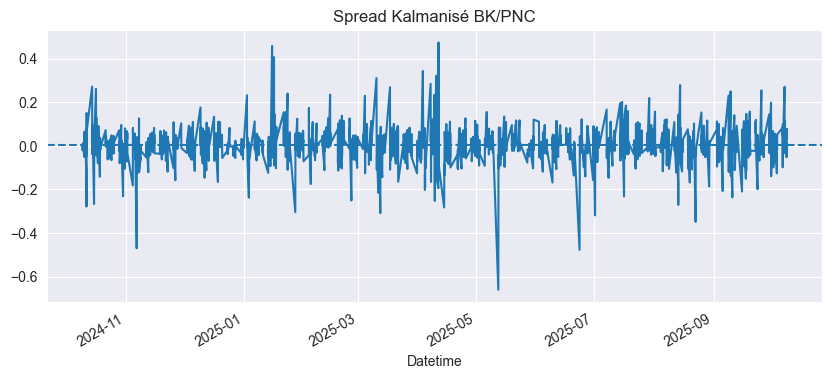

In [92]:
import matplotlib.pyplot as plt
from src.pair_selection_dynamic import kalman_beta_alpha, half_life

a, b = pairs_dyn.loc[9, ['ticker_a','ticker_b']]
df = pd.concat([prices[a], prices[b]], axis=1, keys=[a,b]).dropna()
y, x = df[a], df[b]
beta_t, alpha_t = kalman_beta_alpha(y, x, delta=dyn_params.delta, obs_var=dyn_params.obs_var)

spread = pd.Series(y.values - (alpha_t + beta_t * x.values), index=df.index)
print("Half-life (bars) =", half_life(spread))

plt.figure(figsize=(10,4))
spread.plot()
plt.title(f"Spread Kalmanisé {a}/{b}")
plt.axhline(spread.mean(), linestyle="--")
plt.show()


In [93]:
from statsmodels.tsa.stattools import adfuller

# spread = Série pandas indexée (déjà calculée)
print("moyenne:", float(spread.mean()))
print("std:", float(spread.std()))

adf_stat, pval, *_ = adfuller(spread.dropna(), autolag="AIC")
print("ADF stat:", adf_stat, "p-value:", pval)   # p-value < 0.05 -> stationnaire

moyenne: 0.003909549154827089
std: 0.07596908354843164
ADF stat: -33.12259043055736 p-value: 0.0
